## Прогнозирование спроса
Краткое описание:
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.

Задача:
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

Метрика качества:
`WAPE:
def wape(y_true: np.array, y_pred: np.array):
return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))`

- sales_df_train.csv –данные по продажам за скользящий год для обучения.
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата;
    - pr_sales_type_id – флаг наличия промо;
    - pr_sales_in_units – число проданных товаров всего (промо и без);
    - pr_promo_sales_in_units – число проданных товаров с признаком промо;
    - pr_sales_in_rub – продажи в РУБ всего (промо и без);
    - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
- pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - pr_group_id – захэшированная группа товара;
    - pr_cat_id – захэшированная категория товара;
    - pr_subcat_id – захэшированная подкатегория товара;
    - pr_sku_id – захэшированное id товара;
    - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
- pr_st.csv – данные по магазинам.
    - st_id – захэшированное id магазина;
    - st_city_id – захэшированное id города;
    - st_division_code id – захэшированное id дивизиона;
    - st_type_format_id – id формата магазина;
    - st_type_loc_id – id тип локации/окружения магазина;
    - st_type_size_id – id типа размера магазина;
    - st_is_active – флаг активного магазина на данный момент.
- sales_submission.csv – пример файла с результатом работы модели прогноза спроса.
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата (день);
    - target – спрос в ШТ.

### Libraries

In [2]:
# Cloud Storage
# from google.cloud import storage
# storage_client = storage.Client(project='******')

In [3]:
# !pip install phik
# !pip install catboost

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import phik
from phik.report import plot_correlation_matrix
from catboost import CatBoostRegressor, Pool
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
warnings.filterwarnings('ignore')

### EDA

In [5]:
try:
    sales_df_train = pd.read_csv('sp_sales_task/sales_df_train.csv', parse_dates=['date'])
    shops = pd.read_csv('sp_sales_task/st_df.csv')
    products = pd.read_csv('sp_sales_task/pr_df.csv')
    holiday = pd.read_csv('holidays_covid_calendar.csv')
except:
    sales_df_train = pd.read_csv('/content/sales_df_train.csv', parse_dates=['date'])
    shops = pd.read_csv('/content/st_df.csv')
    products = pd.read_csv('/content/pr_df.csv')
    holiday = pd.read_csv('/content/holidays_covid_calendar.csv')

In [6]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804207 entries, 0 to 804206
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    804207 non-null  object        
 1   pr_sku_id                804207 non-null  object        
 2   date                     804207 non-null  datetime64[ns]
 3   pr_sales_type_id         804207 non-null  int64         
 4   pr_sales_in_units        804207 non-null  float64       
 5   pr_promo_sales_in_units  804207 non-null  float64       
 6   pr_sales_in_rub          804206 non-null  float64       
 7   pr_promo_sales_in_rub    804206 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 49.1+ MB


In [7]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [9]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


In [10]:
holiday = holiday[['date', 'holiday']]
holiday['date'] = pd.to_datetime(holiday['date'], format='%d.%m.%Y')

In [11]:
sales_df_train = sales_df_train.merge(holiday, on='date', how='left')
sales_df_train.sample()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday
332330,f7e6c85504ce6e82442c770f7c8606f0,9001c4cfc8045055359ea084aa22698d,2023-01-13,1,1.0,1.0,242.0,242.0,0


Уникальное количество товаров

In [12]:
len(sales_df_train['pr_sku_id'].unique())

1987

Уникальное количество магазинов

In [13]:
len(sales_df_train['st_id'].unique())

12

Проверка наличия явных дубликатов

In [14]:
display(sales_df_train.duplicated().sum())
display(shops.duplicated().sum())
display(products.duplicated().sum())

0

0

0

Вывод: Дубликатов и пропусков не обнаружено.

#### Объединение датафреймов

Объединим данные по магазинам и товарам в одну таблицу для выведения активных магазинов

In [15]:
total = sales_df_train.merge(shops, on='st_id', how='left').merge(products, on='pr_sku_id', how='left')
index_no_active = total.index[total['st_is_active']== 0].tolist()
total = total.drop(index=index_no_active) #удаление информации по неактивным магазинам
total = total.drop(['st_is_active'], axis=1) #удаление ненужного признака (в нём осталось только одно значение)

In [16]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803566 entries, 0 to 804206
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    803566 non-null  object        
 1   pr_sku_id                803566 non-null  object        
 2   date                     803566 non-null  datetime64[ns]
 3   pr_sales_type_id         803566 non-null  int64         
 4   pr_sales_in_units        803566 non-null  float64       
 5   pr_promo_sales_in_units  803566 non-null  float64       
 6   pr_sales_in_rub          803565 non-null  float64       
 7   pr_promo_sales_in_rub    803565 non-null  float64       
 8   holiday                  803566 non-null  int64         
 9   st_city_id               803566 non-null  object        
 10  st_division_code         803566 non-null  object        
 11  st_type_format_id        803566 non-null  int64         
 12  st_type_loc_id  

#### Нулевые значения в целевом признаке

In [17]:
sales_units_zero = total[total['pr_sales_in_units'] == 0]
display(
    'нулевые продажи в шт и руб:',
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count(),
    'их доля в данных, %:',
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2)
)
display(
    'нулевые продажи в шт, но не нулевые в рублях:',
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count(),
    'их доля в данных, %:',
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2)
)

'нулевые продажи в шт и руб:'

416

'их доля в данных, %:'

0.05

'нулевые продажи в шт, но не нулевые в рублях:'

60214

'их доля в данных, %:'

7.49

В данных имеются записи, которые можно удалить (их доля 7.53%): нулевые значения в количестве проданных товаров и их стоимости

In [18]:
total = total.loc[total['pr_sales_in_units'] != 0]

#### Отрицательные значения в целевом признаке

In [19]:
display(
    'количество записей возвратов:',
    total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count(),
    'их доля в данных, %:',
    round(total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count() / total['pr_sales_in_units'].count() * 100, 2)
)

'количество записей возвратов:'

66

'их доля в данных, %:'

0.01

Удаление записей возврата

In [20]:
total = total.loc[total['pr_sales_in_units'] > 0]
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742870 entries, 0 to 804206
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    742870 non-null  object        
 1   pr_sku_id                742870 non-null  object        
 2   date                     742870 non-null  datetime64[ns]
 3   pr_sales_type_id         742870 non-null  int64         
 4   pr_sales_in_units        742870 non-null  float64       
 5   pr_promo_sales_in_units  742870 non-null  float64       
 6   pr_sales_in_rub          742869 non-null  float64       
 7   pr_promo_sales_in_rub    742869 non-null  float64       
 8   holiday                  742870 non-null  int64         
 9   st_city_id               742870 non-null  object        
 10  st_division_code         742870 non-null  object        
 11  st_type_format_id        742870 non-null  int64         
 12  st_type_loc_id  

#### Проанализируем целевую переменную `pr_sales_in_units`

In [21]:
total['pr_sales_in_units'].describe()

count    742870.000000
mean          5.447509
std          13.803526
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

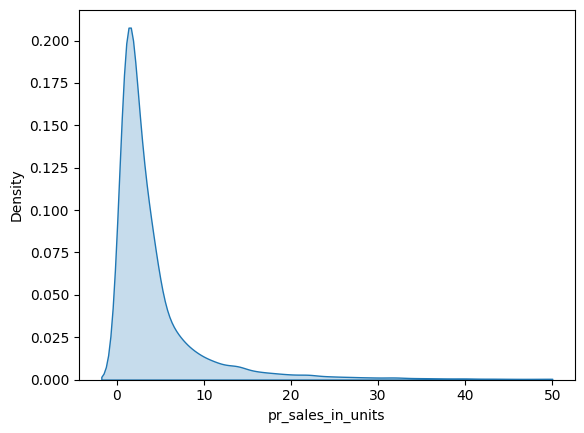

In [22]:
sns.kdeplot(total, x='pr_sales_in_units', clip=(-10, 50), fill=True);

Cреднее значение больше медианного, наблюдается правосторонняя асимметрия. Распределение целевой переменной `pr_sales_in_units` отличается от нормального.

#### Корреляция между категориальными признаками

In [23]:
categ_cols = [
    'st_id', 'pr_sales_type_id', 'st_city_id', 'st_division_code',
    'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_group_id',
    'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id', 'holiday'
    ]
phik_overview = total[categ_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_type_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id', 'holiday']


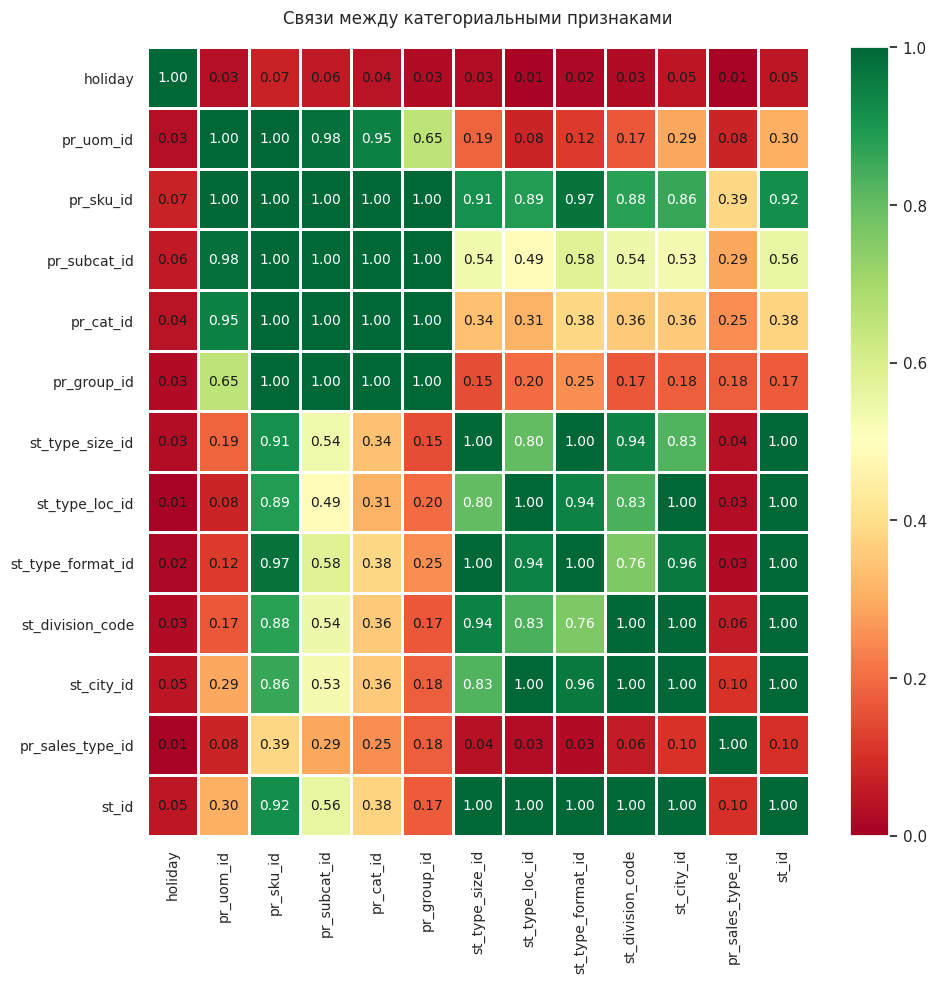

In [24]:
sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=1.0, figsize=(10, 10))

plt.title('Связи между категориальными признаками', fontsize=12, y=1.02)
plt.tight_layout()

Наблюдается сильная зависимость между категориальными признаками, что вполне логично.
Удаление зависимых признаков.

In [25]:
total = total.drop(
    ['pr_uom_id', 'pr_subcat_id', 'pr_cat_id', 'pr_group_id',
     'st_type_size_id', 'st_type_loc_id', 'st_type_format_id',
     'st_division_code', 'st_city_id', 'pr_sales_type_id'], axis=1)

#### Корреляция между числовыми признаками

In [26]:
quant_cols = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
phik_overview_q = total[quant_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']


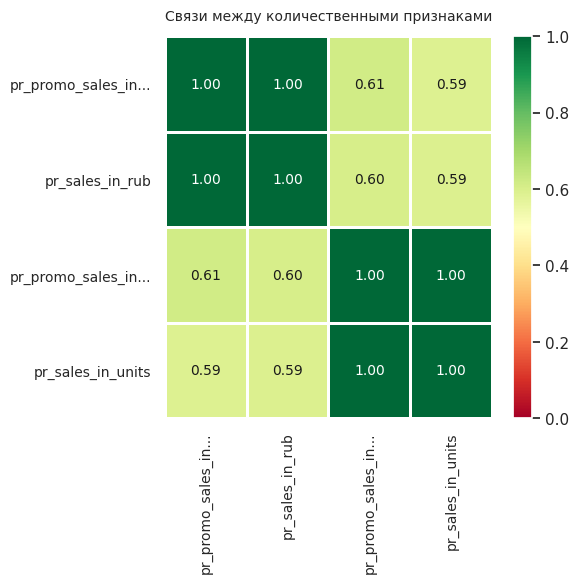

In [27]:
sns.set()
plot_correlation_matrix(phik_overview_q.values,
                        x_labels=phik_overview_q.columns,
                        y_labels=phik_overview_q.index,
                        vmin=0, vmax=1,
                        fontsize_factor=1.0, figsize=(6, 6))

plt.title('Связи между количественными признаками', fontsize=10, y=1.02)
plt.tight_layout()

Высокая корреляция наблюдается у признаков:
- Целевой признак `pr_sales_in_units` и `pr_promo_sales_in_units`
- `pr_promo_sales_in_units` и `pr_promo_sales_in_rub`
- `pr_sales_in_rub` и `pr_promo_sales_in_rub`
    
Средняя корреляция наблюдается у признаков:

- Целевой признак `pr_sales_in_units` и `pr_sales_in_rub`
- Целевой признак `pr_sales_in_units` и `pr_promo_sales_in_rub`
- `pr_promo_sales_in_units` и `pr_sales_in_rub`

Удалим сильно коррелированные столбцы

In [28]:
total = total.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1)

#### Распределение целевого признака между выходными и буднями

In [29]:
holiday_1_units = total[total['holiday'] == 1]['pr_sales_in_units'].sum()
holiday_0_units = total[total['holiday'] == 0]['pr_sales_in_units'].sum()
holiday_1_rub = total[total['holiday'] == 1]['pr_sales_in_rub'].sum()
holiday_0_rub =  total[total['holiday'] == 0]['pr_sales_in_rub'].sum()

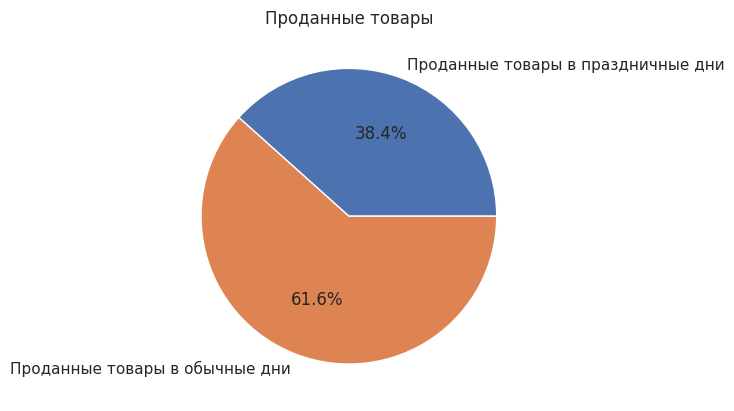

In [30]:
labels = 'Проданные товары в праздничные дни', 'Проданные товары в обычные дни'
sizes = [holiday_1_units, holiday_0_units]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Проданные товары')
plt.show()

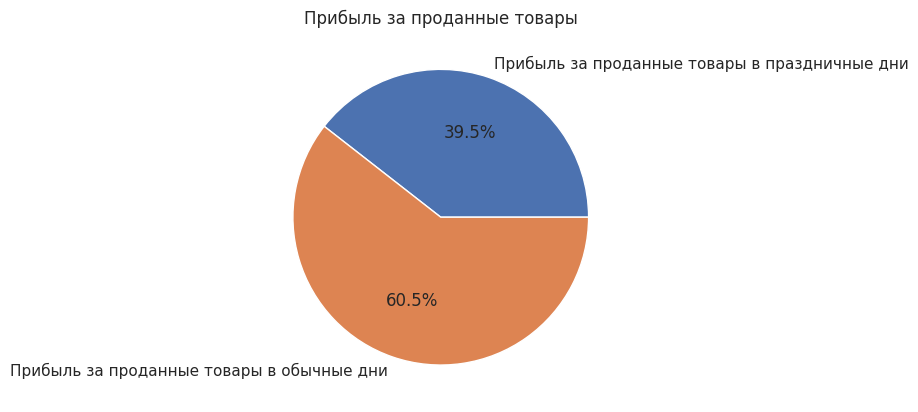

In [31]:
labels = 'Прибыль за проданные товары в праздничные дни', 'Прибыль за проданные товары в обычные дни'
sizes = [holiday_1_rub, holiday_0_rub]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Прибыль за проданные товары')
plt.show()

#### Распределение целевого признака по датам

In [32]:
total=total.set_index('date')

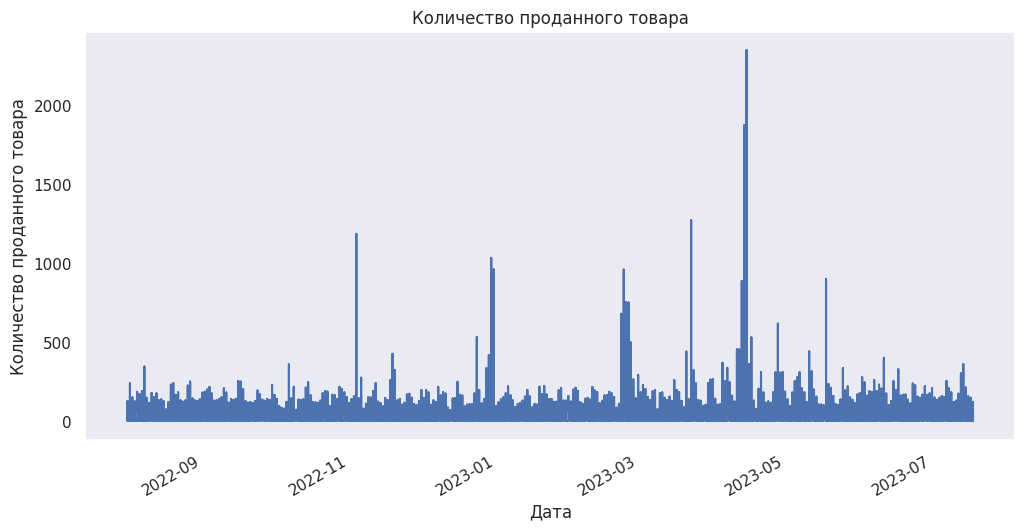

In [33]:
total['pr_sales_in_units'].plot(figsize=(12,6));
plt.title("Количество проданного товара")
plt.xlabel("Дата")
plt.ylabel("Количество проданного товара")
plt.grid();

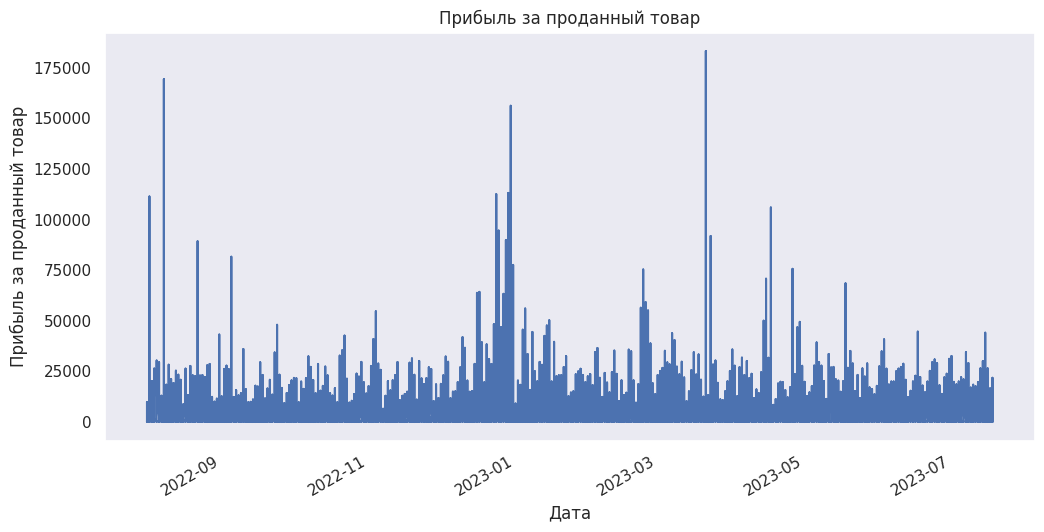

In [34]:
total['pr_sales_in_rub'].plot(figsize=(12,6));
plt.title("Прибыль за проданный товар")
plt.xlabel("Дата")
plt.ylabel("Прибыль за проданный товар")
plt.grid();

#### Скользящее среднее

In [35]:
total['mean'] = total['pr_sales_in_units'].rolling(15).mean()

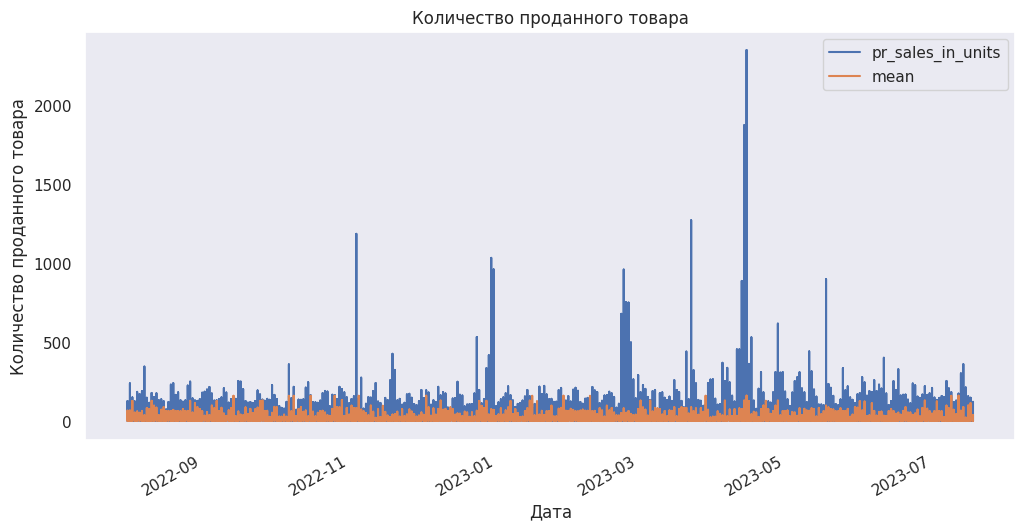

In [36]:
total['pr_sales_in_units'].plot(figsize=(12,6));
total['mean'].plot(figsize=(12,6));
plt.title("Количество проданного товара")
plt.xlabel("Дата")
plt.ylabel("Количество проданного товара")
plt.grid()
plt.legend();

In [37]:
total = total.drop(columns=['mean'])

#### Resampling по суммарным значениям за день

In [38]:
total_resamp = total.resample('1D').sum()

#### Графики среднего значения за 1 день для параметров `pr_sales_in_units`, `pr_sales_in_rub`

In [39]:
columns = ['pr_sales_in_units', 'pr_sales_in_rub']

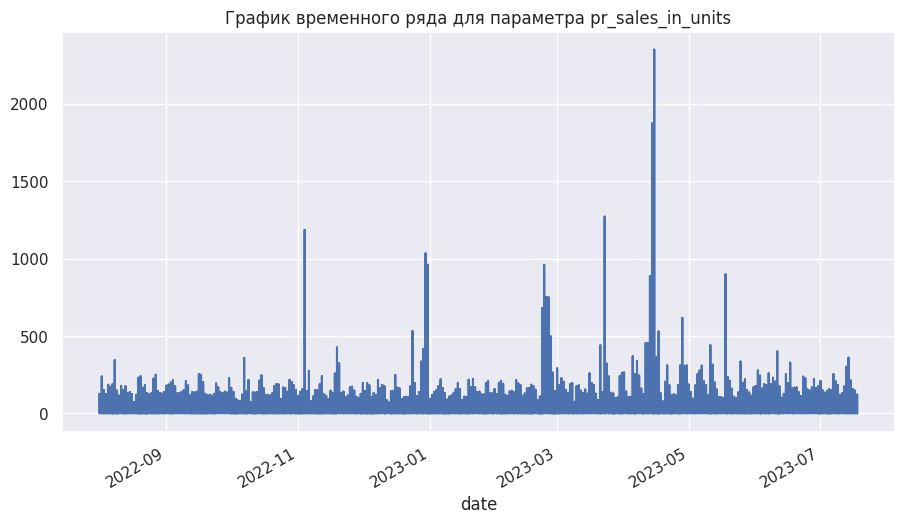

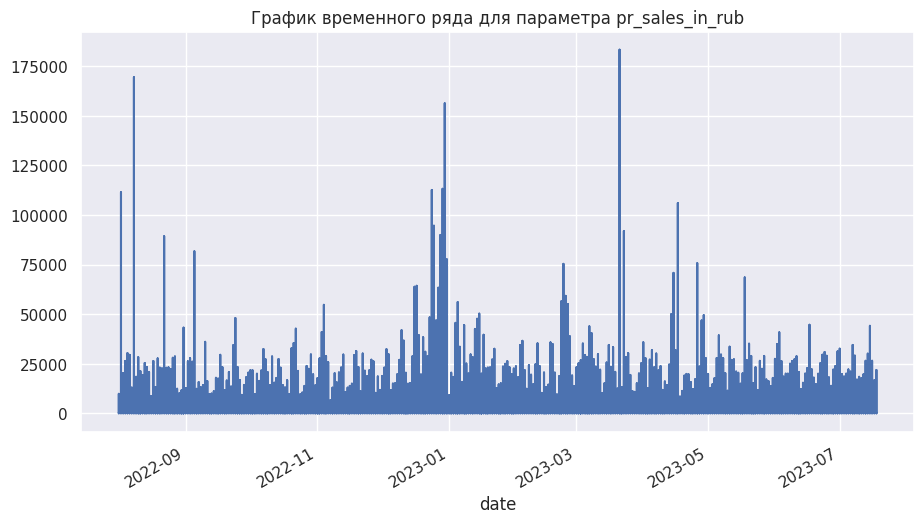

In [40]:
for num in columns:
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(121)
    plot1 = total[num].plot(title= 'График временного ряда для параметра ' +  num)
    plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
    plt.show()

#### Графики скользящего среднего значения за 1 день для параметров `pr_sales_in_units`, `pr_sales_in_rub`

In [41]:
total['rolling_mean_units'] = total['pr_sales_in_units'].rolling(10).mean()
total['rolling_mean_rub'] = total['pr_sales_in_rub'].rolling(10).mean()

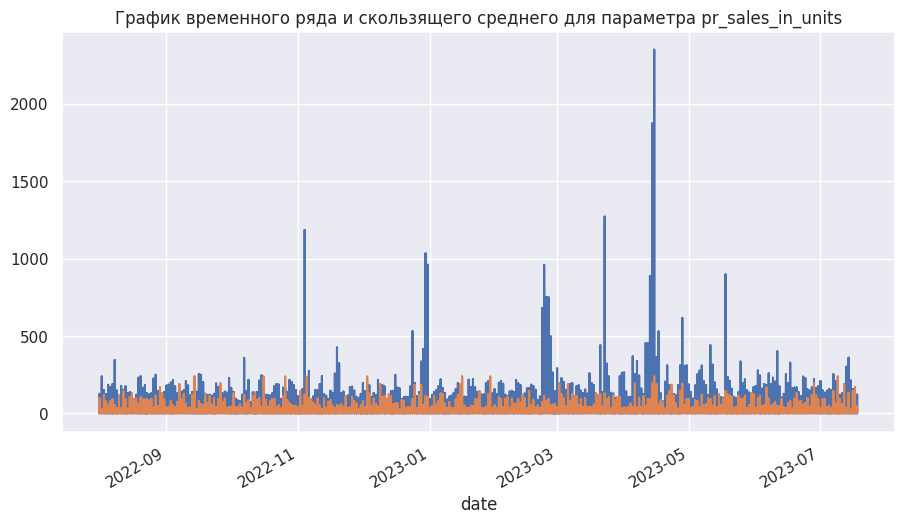

In [42]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_units'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_units')
plot2 = total['rolling_mean_units'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()

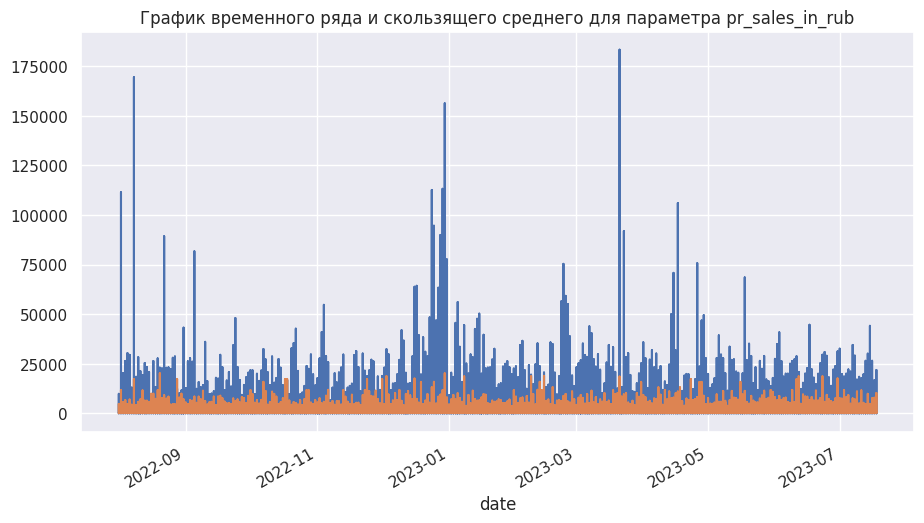

In [43]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_rub'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_rub')
plot2 = total['rolling_mean_rub'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()

#### Изучение сезонности

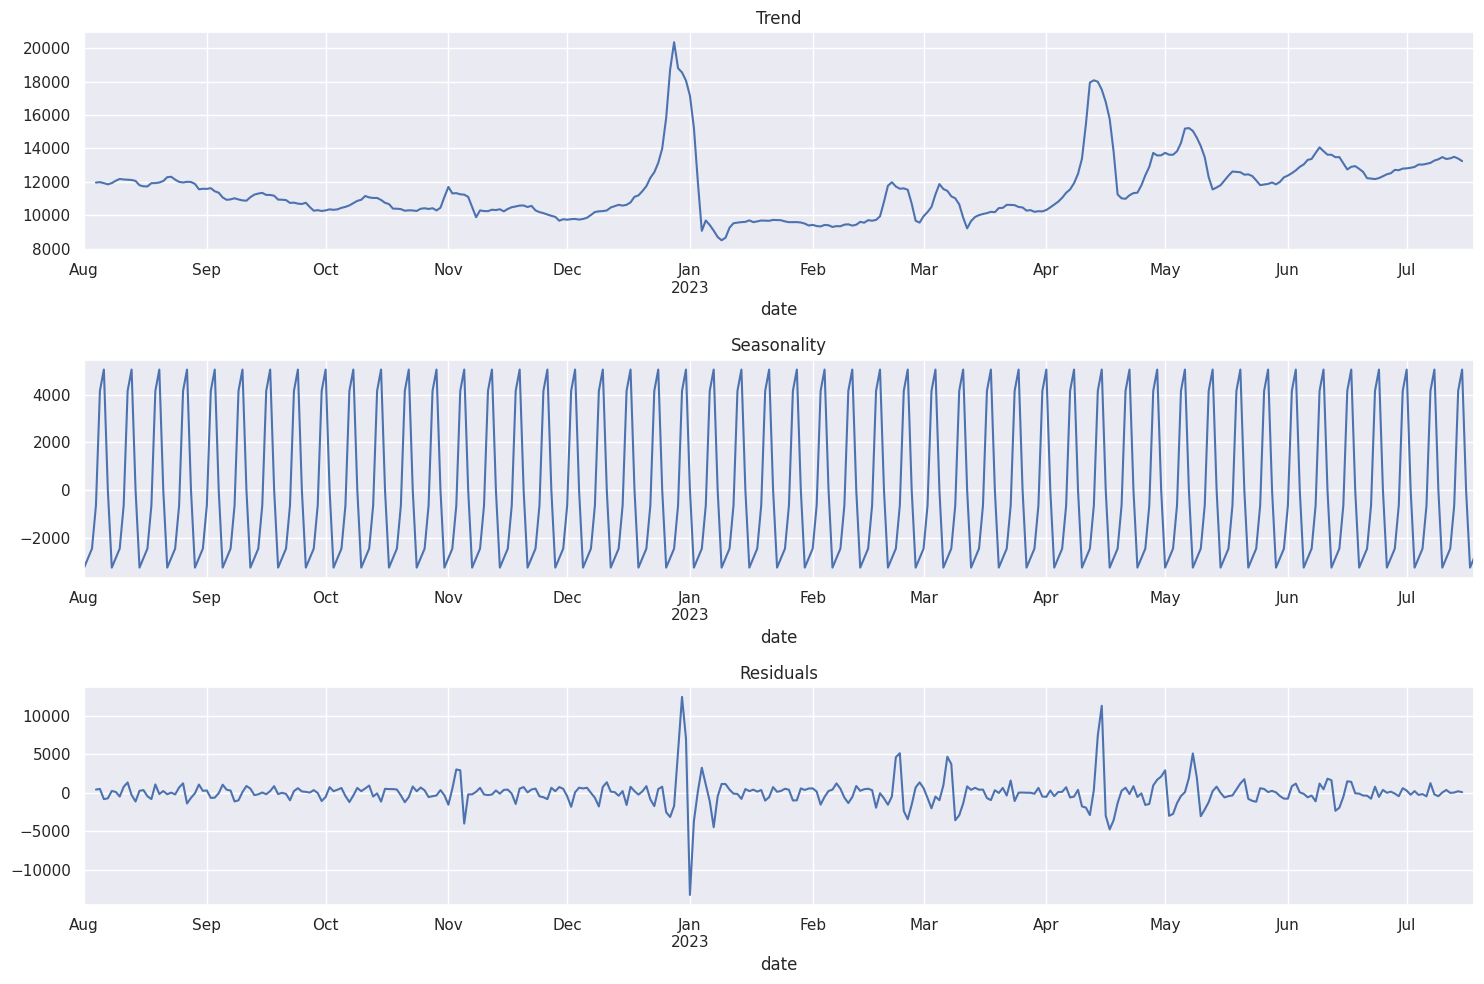

In [44]:
decomposed_units = seasonal_decompose(total_resamp['pr_sales_in_units'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод:**
<br>На графике тренда видим, что продажи растут в дни государственных праздников: Новый год, 23 февраля, 8 марта, майские праздники, 12 июня образуются локальные пики.
Самый большой пик продаж с конца декабря и  в первые 5 дней  спрос падает. Это связано с подготовкой покупателей к корпоративам и празднованию Нового года.
После первой декады апреля и до начала сентября продажи выше, чем в остальную часть года. Это связано с сезоном пикников и  поездками на дачи.

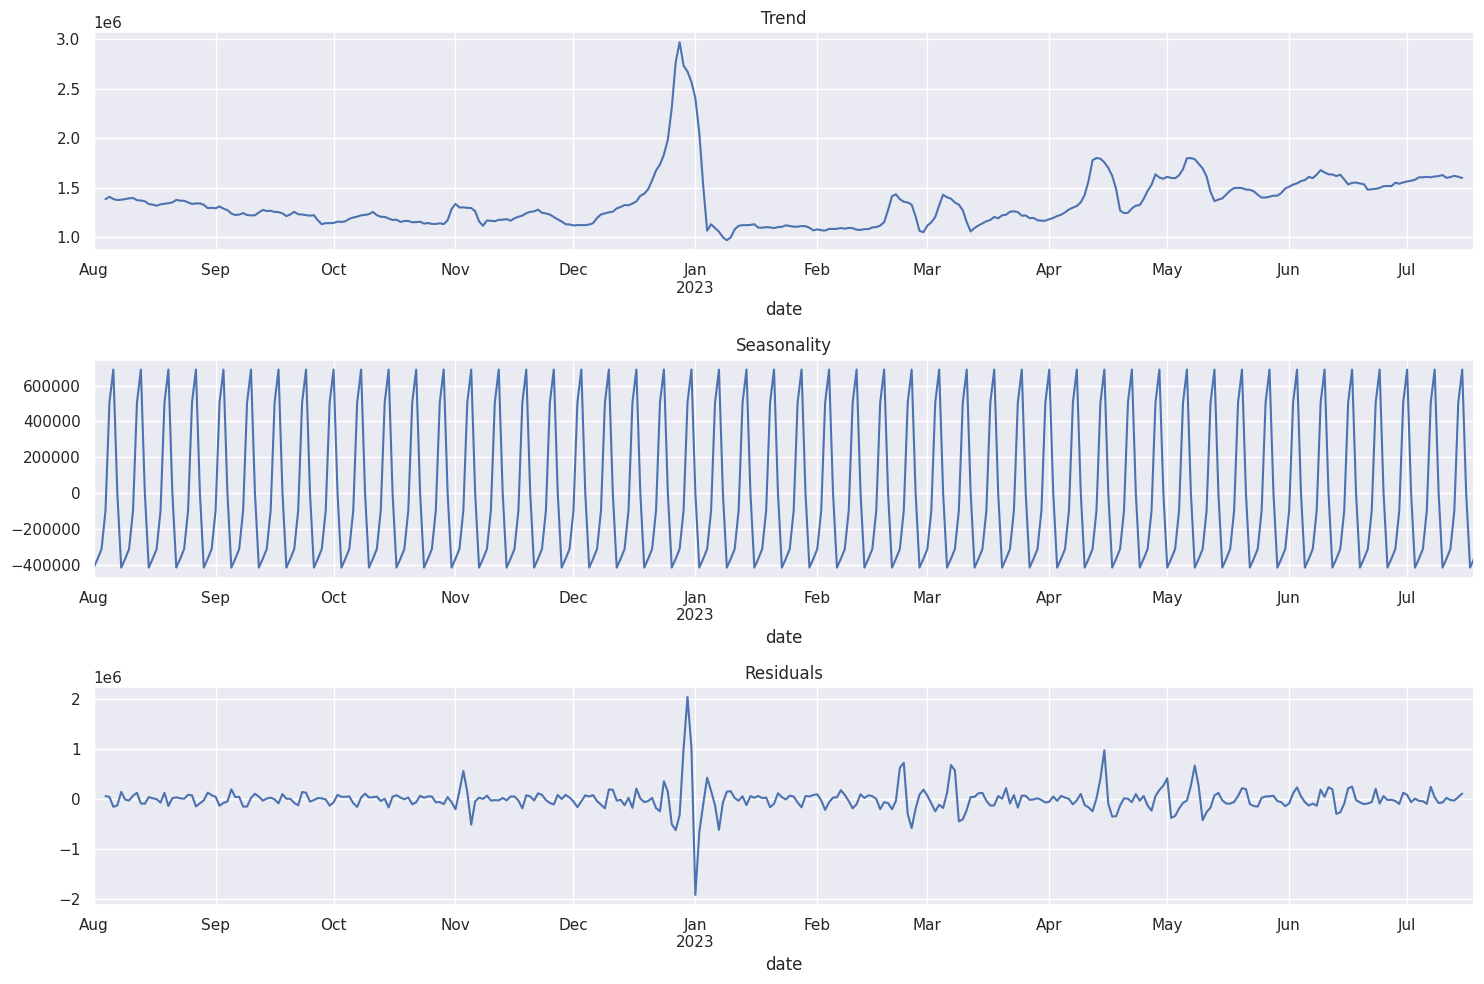

In [45]:
decomposed_rub = seasonal_decompose(total_resamp['pr_sales_in_rub'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_rub.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_rub.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_rub.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

#### Сезонность и тренд за две недели

In [46]:
data_week = total_resamp['pr_sales_in_rub']
data_week = data_week['2023-06-24':'2023-07-11']

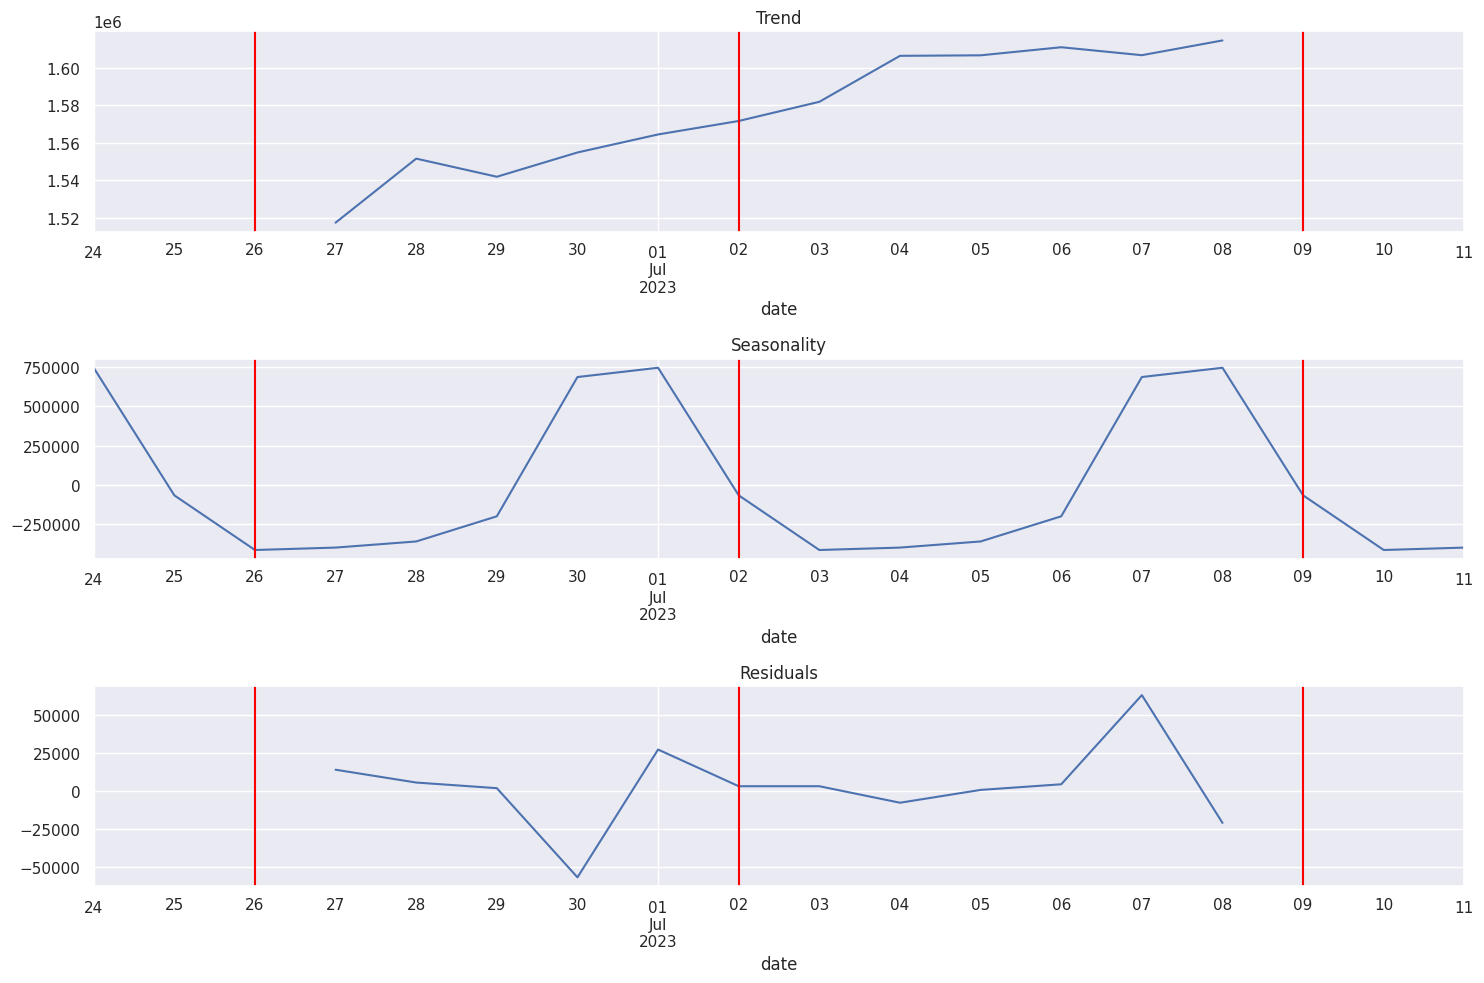

In [47]:
decomposed_week = seasonal_decompose(data_week)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

**Вывод:**
<br>При анализе тренда за 2 недели видим, что продажи  растут в пятницу и субботу, в воскресенье отмечается спад. Уровень продаж в течение недели ниже, чем в пиковые дни.

In [48]:
data_week_1 = total_resamp['pr_sales_in_rub']
data_week_1 = data_week_1['2023-04-02':'2023-04-17']

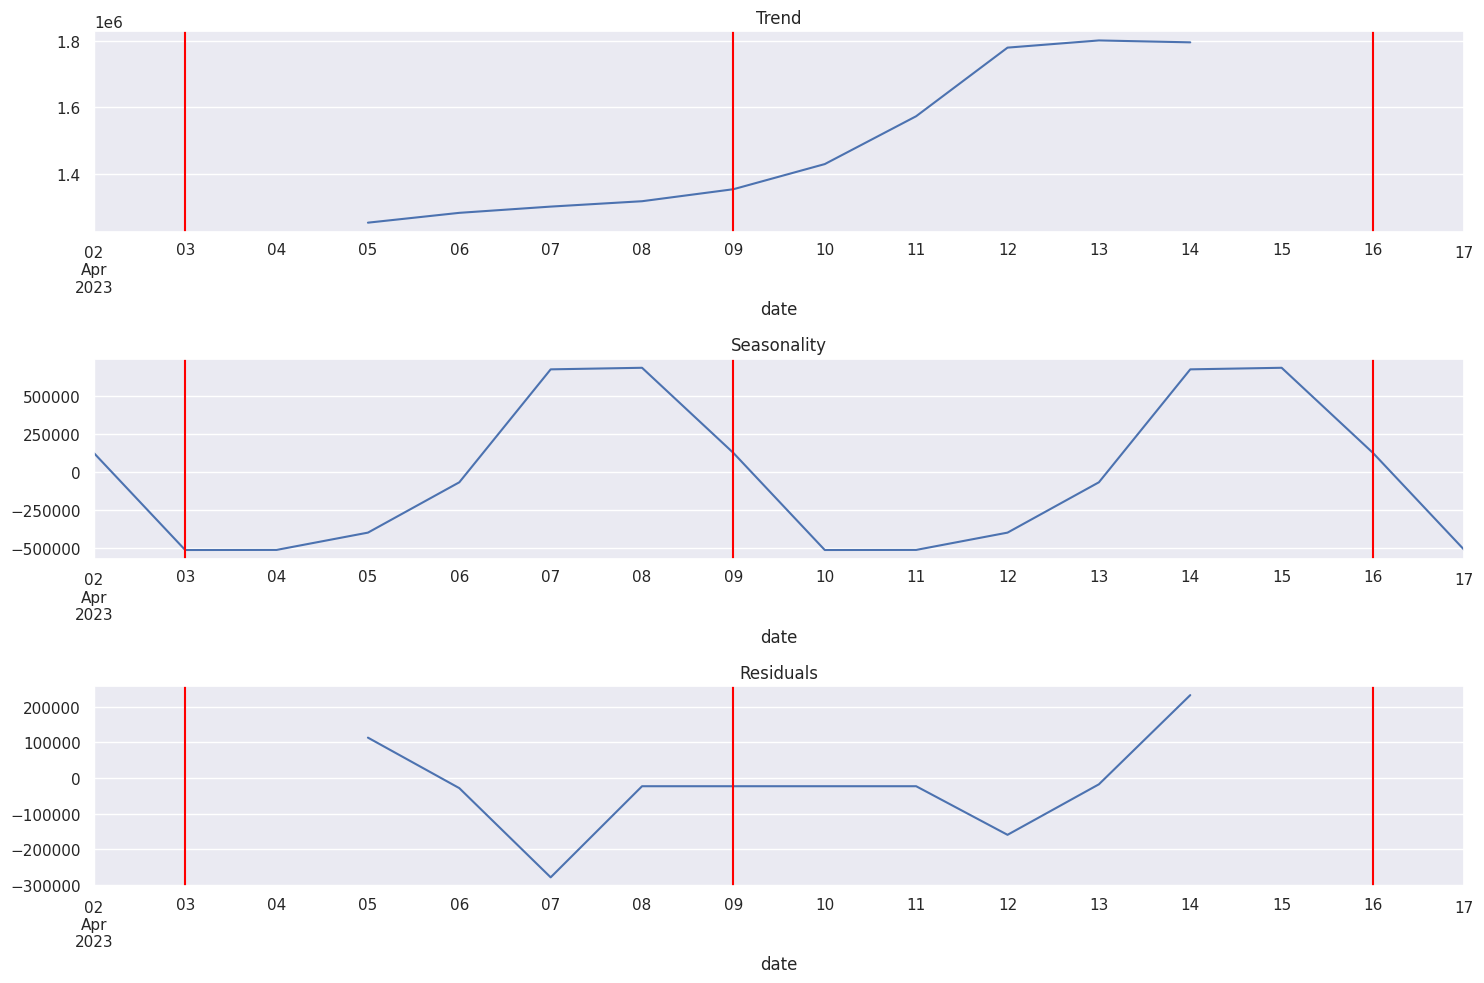

In [49]:
decomposed_week_1 = seasonal_decompose(data_week_1)

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed_week_1.trend.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Trend')

plt.subplot(312)
decomposed_week_1.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Seasonality')

plt.subplot(313)
decomposed_week_1.resid.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

**Вывод:**
- Продажи резко растут в пятницу и субботу, в воскресенье начинают падать в течении недели спрос маленький. Клиенты чаще совершают покупки перед выходными днями и в выходные.

#### Проверка на стационарность

In [70]:
test = adfuller(total_resamp['pr_sales_in_units'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
  print('есть единичные корни, ряд не стационарен')
else:
  print('единичных корней нет, можем предположить, что ряд стационарен')

adf:  -3.3127177198604008
p-value:  0.01431947517104467
Critical values:  {'1%': -3.4499043309021955, '5%': -2.870154885338925, '10%': -2.5713597190254385}
единичных корней нет, можем предположить, что ряд стационарен


#### Выводы
- Данные предоставлены за период с 01.08.2022 по 18.07.2023
- Предоставленные датасеты объединены в один датафрейм
- К общему датафрейму добавлена информация о государственных праздниках и выходных днях в РФ
- Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом): им соответствует 729 записей, что составляет 0.08% датасета.
- Распределение целевой переменной `pr_sales_in_units` отличается от нормального: наблюдается правосторонняя асимметрия
- Удалены данные с нулевыми продажами в шт и руб.
- Удалены записи с отрицательным значением целевого признака (действие согласовано с бизнесом)
- Удалены сильно коррелированные признаки
- Данные разложены на три составляющие (для этого осуществлён ресемплинг по одному дню) - сезонность, тренд и остаток:
  - наблюдается рост спроса перед праздничными днями (годовая сезонность)
  - рост спроса в выходные дни (недельная сезонность)
- Временной ряд может быть стационарен, о чём свидетельствует тест Дики-Фуллера, но наличие тренда и сезонности говорят об обратном

### Feature engineering

Удаление пропусков и сортировка по дате

In [51]:
total = total.dropna()
total = total.sort_values(by='date')

#### Добавление новых признаков

In [52]:
total_s = total.drop(['pr_sales_in_rub', 'holiday', 'rolling_mean_units', 'rolling_mean_rub'], axis=1)
total_s = total_s.reset_index()
total_s = total_s.groupby(['date', 'st_id',  'pr_sku_id']).sum().reset_index()
total_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614766 entries, 0 to 614765
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               614766 non-null  datetime64[ns]
 1   st_id              614766 non-null  object        
 2   pr_sku_id          614766 non-null  object        
 3   pr_sales_in_units  614766 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 18.8+ MB


Присоединение таблицы `sales_submission` к основному датафрейму

In [53]:
# total_s = total.drop(['pr_sales_in_rub', 'holiday', 'rolling_mean_units', 'rolling_mean_rub'], axis=1)
# total_s = total_s.reset_index()
try:
    sales_submission_s = pd.read_csv('sp_sales_task/sales_submission.csv', parse_dates=['date'])
except:
    sales_submission_s = pd.read_csv('/content/sales_submission.csv', parse_dates=['date'])
sales_submission_s = sales_submission_s.drop(['target'], axis=1)

In [54]:
total_big = pd.concat([total_s, sales_submission_s], axis=0)
total_big =  total_big.merge(holiday, on='date', how='left')
total_big = total_big.sort_values(by='date')
total_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658460 entries, 0 to 658459
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               658460 non-null  datetime64[ns]
 1   st_id              658460 non-null  object        
 2   pr_sku_id          658460 non-null  object        
 3   pr_sales_in_units  614766 non-null  float64       
 4   holiday            658460 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 30.1+ MB


In [55]:
tb_sku_sorted = total_big.sort_values(['pr_sku_id', 'date'])
tb_sku_sorted.head()

,date,st_id,pr_sku_id,pr_sales_in_units,holiday
391261,2023-03-16,6364d3f0f495b6ab9dcf8d3b5c6e0b01,002c3a40ac50dc870f1ff386f11f5bae,1.0,0
603807,2023-07-13,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,1.0,0
606719,2023-07-14,c81e728d9d4c2f636f067f89cc14862c,0045ebdb1069ff4b3dd3efe628c39cd3,2.0,0
605654,2023-07-14,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2.0,0
608675,2023-07-15,c81e728d9d4c2f636f067f89cc14862c,0045ebdb1069ff4b3dd3efe628c39cd3,1.0,1


Функция для создания дополнительных признаков

In [56]:
#len(sales_submission_s.groupby(['st_id', 'pr_sku_id'])['date'])
def create_features(data, window, max_lag):

  try:
        data['day'] = data['date'].dt.day
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['weekday'] = data['date'].dt.weekday

        # Сортируем данные по столбцам st_id, pr_sku_id и date
        data = data.sort_values(by=['st_id', 'pr_sku_id', 'date'])

        # Группируем данные по столбцах st_id и pr_sku_id
        grouped_data = data.groupby(['st_id', 'pr_sku_id'])

        # Вычисляем скользящее среднее значение pr_sales_in_units для каждой группы
        data['rolling_average'] = (
            grouped_data['pr_sales_in_units']
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(drop=True)
            )

        # Добавляем смещение на 14 дней к столбцу rolling_average
        #data['rolling_average'] = data.groupby(['st_id', 'pr_sku_id'])['rolling_average'].shift(max_lag) код для одного столбца

        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data.groupby(['st_id', 'pr_sku_id'])['rolling_average'].shift(lag, fill_value=0)

        # Создаем столбец с lag значениями pr_sales_in_units
        data['lag_pr_sales_in_units'] = grouped_data['pr_sales_in_units'].shift(max_lag, fill_value=0)
  except ValueError:
        print("Oops!  That was no valid number.  Try again...")
  return data

Применение функции к датафрейму

In [57]:
data = create_features(tb_sku_sorted, 3, 14)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658460 entries, 428974 to 293851
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   658460 non-null  datetime64[ns]
 1   st_id                  658460 non-null  object        
 2   pr_sku_id              658460 non-null  object        
 3   pr_sales_in_units      614766 non-null  float64       
 4   holiday                658460 non-null  int64         
 5   day                    658460 non-null  int64         
 6   month                  658460 non-null  int64         
 7   year                   658460 non-null  int64         
 8   weekday                658460 non-null  int64         
 9   rolling_average        620752 non-null  float64       
 10  lag_1                  621208 non-null  float64       
 11  lag_2                  621556 non-null  float64       
 12  lag_3                  621881 non-null 

In [58]:
data = data.fillna(0)
data = data.sort_values(by='date')

Разделение датафреймов

In [59]:
total = data.loc[(data['date'] <= total_s['date'].max()) & (data['date'] >= total_s['date'].min())]
total = total.set_index('date')

Вывод: добавлены новые признаки к датафрейму

#### Выделение категориальных и количественных признаков

In [60]:
RS = 42
#num_features = ['holiday', 'rolling_mean_units', 'rolling_mean_rub', 'day', 'month', 'year', 'weekday']
cat_features = ['st_id', 'pr_sku_id']

Выделены категориальные признаки, установлен `random state`

#### Разделение данных на обучающую и тестовую выборки

In [61]:
X = total.drop(['pr_sales_in_units'], axis=1)
y = total['pr_sales_in_units']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((553289, 23), (61477, 23), (553289,), (61477,))

Выделен целевой признак, удалены признаки с большим количеством уникальных значений (вынужденная мера в целях сохранения производительности)

#### Применение `OneHotEncoder` и `StandardScaler`

Использование техник кодирования и масштабирования, чтобы привести данные к виду, подходящему для обучения линейной модели

In [63]:
def data_encoding(X_train, X_test):
    encoder = OrdinalEncoder()
    encoder.fit(X_train[cat_features])

    # X_train_oe = pd.DataFrame(encoder.transform(X_train[cat_features]), columns=cat_features, index=X_train.index)
    # X_train_oe = X_train_oe.merge(X_train.drop(cat_features, axis=1), how='left', left_index=True, right_index=True, sort=False)
    # X_test_oe = pd.DataFrame(encoder.transform(X_test[cat_features]), columns=cat_features, index=X_test.index)
    # X_test_oe = X_test_oe.merge(X_test.drop(cat_features, axis=1), how='left', left_index=True, right_index=True, sort=False)

    # scaler = StandardScaler()
    # scaler.fit(X_train[num_features])

    # X_train_sc = pd.DataFrame(scaler.transform(X_train[num_features]), columns=num_features, index=X_train.index)
    # X_test_sc = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index)

    # X_train_enc = X_train_oe.merge(X_train_sc, how='left', left_index=True, right_index=True, sort=False)
    # X_test_enc = X_test_oe.merge(X_test_sc, how='left', left_index=True, right_index=True, sort=False)

    return X_train_sc, X_test_sc

In [64]:
# X_train_enc, X_test_enc = data_encoding(X_train, X_test)
# X_train_enc.shape, X_test_enc.shape

При попытке кодирования данных происходит падение ядра. Проведение операции на данном этапе осложнено

### Modeling

#### Кросс-валидатор временных рядов

In [65]:
tscv = TimeSeriesSplit(n_splits=round((X_train.shape[0] / X_test.shape[0]) - 1))

#### Метрика для определения качества модели

In [66]:
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

#### Модель `LinearRegression`

In [ ]:
# model_lr = LinearRegression()

# param_lr = {}#'fit_intercept': [True, False], 'normalize': [True, False]}

# lr_gs = GridSearchCV(estimator=model_lr, param_grid=param_lr, cv=tscv, scoring=make_scorer(wape, greater_is_better=False))

# lr_gs.fit(X_train, y_train)
# display('Параметры лучшей модели', lr_gs.best_params_)
# display('Показатель wape лучшей модели', lr_gs.best_score_*(-1))

#### Модель `CatBoostRegressor`

In [ ]:
params_cb = (
    {'depth':[7], #[1, 3], [3, 5], [5, 7]
     'l2_leaf_reg': [5], #[1, 3], [3, 5], [5, 7]
     'learning_rate': [0.03], #(0.1, 0.2), (0.05, 0.1), np.arange(0.03, 0.05)
     'iterations': [700]} #n_estimators[100, 300], [300, 500], [500, 700]
    )
model_cbr = CatBoostRegressor(params_cb, random_state=RS, verbose=100)
# model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=2, learning_rate=0.01, iterations=1000, random_state=RS, verbose=100)

# model_cbr.fit(X_train, y_train, cat_features=cat_features)
# cbc_gs = model_cbc.grid_search(params_cb, Pool(X_train, y_train, cat_features=cat_features), cv=tscv, verbose=100)
# display('Лучшие параметры:', model_cbc.get_params())

cbc_gs = GridSearchCV(model_cbr, params_cb, n_jobs=-1, scoring=make_scorer(wape, greater_is_better=False), cv=tscv)
cbc_gs.fit(X_train, y_train, cat_features=cat_features)
display('Параметры лучшей модели', cbc_gs.best_params_)
display('Показатель wape лучшей модели', cbc_gs.best_score_*(-1)) #0.68, 0.676

0:	learn: 16.0810690	total: 1.05s	remaining: 12m 14s
100:	learn: 12.0891907	total: 41.5s	remaining: 4m 5s
200:	learn: 11.4770135	total: 1m 18s	remaining: 3m 15s
300:	learn: 11.0207913	total: 1m 58s	remaining: 2m 36s
400:	learn: 10.6974900	total: 2m 37s	remaining: 1m 57s
500:	learn: 10.4889966	total: 3m 17s	remaining: 1m 18s
600:	learn: 10.3078562	total: 4m 1s	remaining: 39.8s
699:	learn: 10.1713723	total: 4m 40s	remaining: 0us


'Параметры лучшей модели'

{'depth': 7, 'iterations': 700, 'l2_leaf_reg': 5, 'learning_rate': 0.03}

'Показатель wape лучшей модели'

0.5103740933775973

#### Проверка по метрике качества на тестовых данных

In [ ]:
'Показатель wape лучшей модели на тестовой выборке', wape(y_test, model_cbr.predict(X_test)) #wape(y_test, cbc_gs.predict(X_test)

('Показатель wape лучшей модели на тестовой выборке', 0.48316615497259535)

Диаграмма сравнения предсказаний с реальными данными

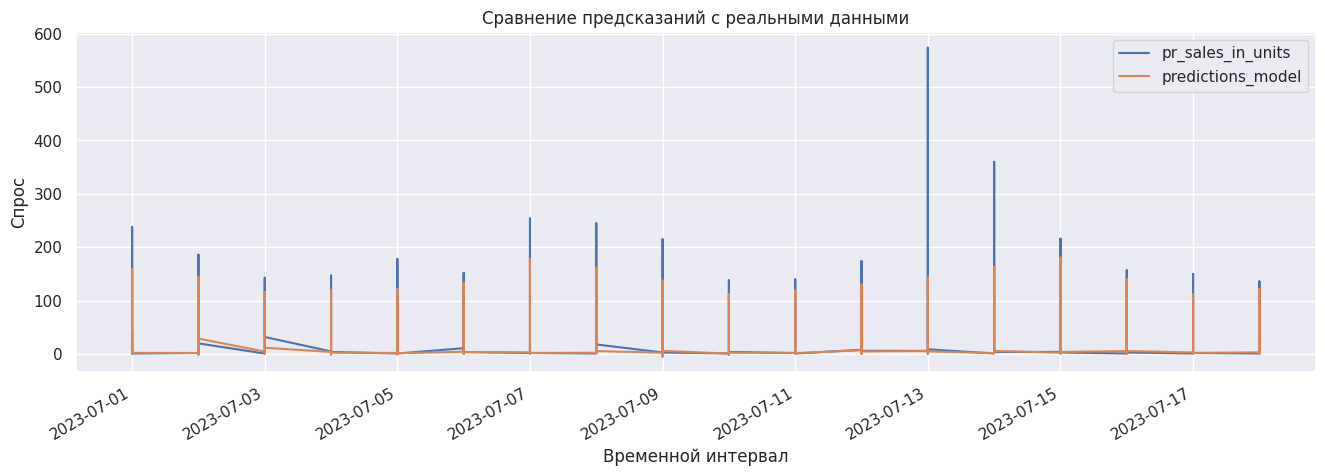

In [ ]:
predictions_model = pd.Series(data = cbc_gs.predict(X_test), name = 'predictions_model', index = X_test.index)

y_test['2023-07-01':'2023-07-31'].plot(figsize=(16,5), grid=True, legend=True)
predictions_model['2023-07-01':'2023-07-31'].plot(grid=True, legend=True)
plt.title('Сравнение предсказаний с реальными данными')
plt.xlabel('Временной интервал')
plt.ylabel('Спрос')
#plt.kind(barplot)
plt.show()

#### Feature importance

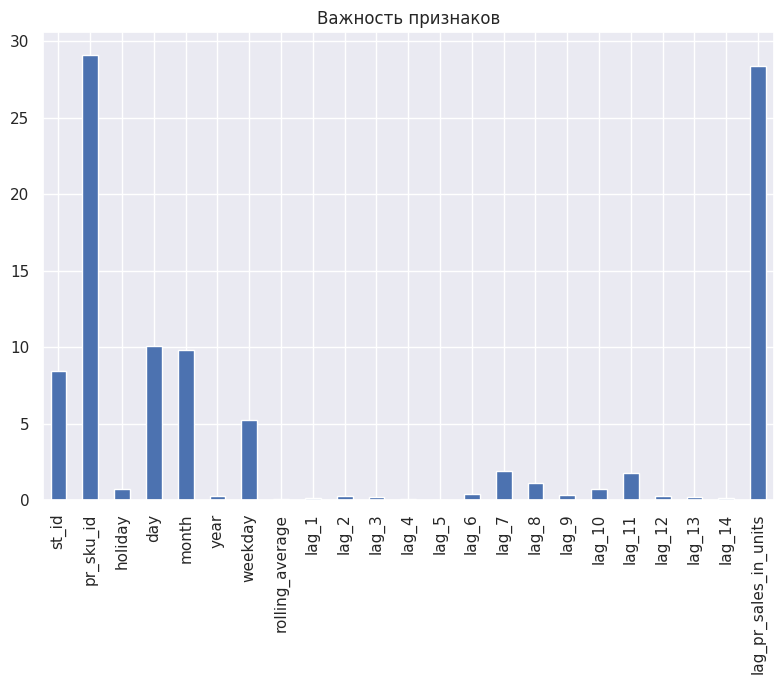

In [ ]:
cbr_fi = pd.Series(cbc_gs.best_estimator_.feature_importances_, X.columns)
fig, ax = plt.subplots(figsize=(8,7))
cbr_fi.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

#### Получение предсказания на следующие две недели

Обучение модели с выбранными параметрами на полном датасете

In [74]:
model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=5, learning_rate=0.03, n_estimators=700, random_state=RS, verbose=100)
model_cbr.fit(X, y, cat_features=cat_features)

0:	learn: 15.6825277	total: 634ms	remaining: 7m 23s
100:	learn: 12.2570184	total: 42.5s	remaining: 4m 11s
200:	learn: 11.6273114	total: 1m 23s	remaining: 3m 28s
300:	learn: 11.1906155	total: 2m 1s	remaining: 2m 41s
400:	learn: 10.8305776	total: 2m 44s	remaining: 2m 2s
500:	learn: 10.5692663	total: 3m 25s	remaining: 1m 21s
600:	learn: 10.3707171	total: 4m 13s	remaining: 41.7s
699:	learn: 10.2195330	total: 4m 52s	remaining: 0us


Открытие файла, установка даты индексом

In [75]:
sales_submission_s = data.loc[(data['date'] > total_s['date'].max())]
sales_submission_s = sales_submission_s.drop(['pr_sales_in_units'], axis=1)
sales_submission_s = sales_submission_s.set_index('date')
sales_submission_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43694 entries, 2023-07-19 to 2023-08-01
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   st_id                  43694 non-null  object 
 1   pr_sku_id              43694 non-null  object 
 2   holiday                43694 non-null  int64  
 3   day                    43694 non-null  int64  
 4   month                  43694 non-null  int64  
 5   year                   43694 non-null  int64  
 6   weekday                43694 non-null  int64  
 7   rolling_average        43694 non-null  float64
 8   lag_1                  43694 non-null  float64
 9   lag_2                  43694 non-null  float64
 10  lag_3                  43694 non-null  float64
 11  lag_4                  43694 non-null  float64
 12  lag_5                  43694 non-null  float64
 13  lag_6                  43694 non-null  float64
 14  lag_7                  43694 non-null

Добавление предсказаний в таблицу, удаление ненужных признаков

In [77]:
sales_submission_s['target'] = model_cbr.predict(sales_submission_s)
sales_submission_s['target'] = round(sales_submission_s['target'], 0)
sales_submission_s = sales_submission_s.reset_index()
sales_submission_s = sales_submission_s.drop(['holiday', 'day', 'month', 'year', 'weekday'], axis=1)
sales_submission_s = sales_submission_s[['st_id', 'pr_sku_id', 'date', 'target']]
sales_submission_s.head()

,st_id,pr_sku_id,date,target
0,6364d3f0f495b6ab9dcf8d3b5c6e0b01,72740338e91de3ccc276b9bc7681bd0d,2023-07-19,1.0
1,6364d3f0f495b6ab9dcf8d3b5c6e0b01,e6449990bb6a761a964e58dd95f7a479,2023-07-19,2.0
2,42a0e188f5033bc65bf8d78622277c4e,4ba72d594b35e41cb3e066397eecdfba,2023-07-19,3.0
3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,3bb2524fb92c7c5fec7a4223e4fadf68,2023-07-19,1.0
4,c81e728d9d4c2f636f067f89cc14862c,b43e19936412e99b8efd1f9061d3f3c7,2023-07-19,5.0


#### Сохранение результатов

Сохранение результата предсказания

In [78]:
sales_submission_s.to_csv('sales_submission_pred.csv', encoding='utf-8')

Запись модели в файл

In [79]:
with open('model_cbr.pkl', 'wb') as f:
  pickle.dump(model_cbr, f)

### Заключение

- Предоставленные данные объединены в единый датафрейм, к ним присоединена информация о праздничных и выходных днях в РФ
- Проведено исследование на корреляцию в признаках, удалены зависимые признаки
- Проведено исследование на сезонность и тренд
- Добавлены синтетические признаки (лаги, даты, скользящее среднее)
- Возникли проблемы при попытке применения техник кодирования, в связи с чем из исследования исключены простые модели ML: линейная регрессия, случайный лес, дерево решений
- Для запуска `ARIMA` недостаточно ресурсов
- Для прогнозирования применена модель градиентного бустинга, т.к. она может одинаково хорошо работает с категориальными и количественными признаками
- При помощи `GridSearch` подобраны оптимальные параметры модели с показателем `wape` на трейне 0.51
- На тестовой выборке показатель `wape` получен 0.48
- Анализ значимости признаков показал, что наиболее важный признак - `lag_pr_sales_in_units` и `pr_sku_id`
- Конечная модель обучена на полном наборе данных